# Voxel debugging

This is a notebook to work on debugging the voxel properties. Here you can check the absorption, emissivity, and intensity of the voxel, as well as perform gaussian fits to these properties. This is to help ensure everything works as expected (the emissivity and absorption should have the same gaussian line width).

In [1]:
from kosmatau3d import models
import numpy as np
from time import time
import matplotlib.pyplot as plt
from copy import copy
from scipy.special import erfi, erfc

## Dill grid

In [ ]:
models.dill_grid()

In [2]:
models.constants.dust

'all'

## Standard example

initialised: 0.09943389892578125
calculated: 0.7564899921417236


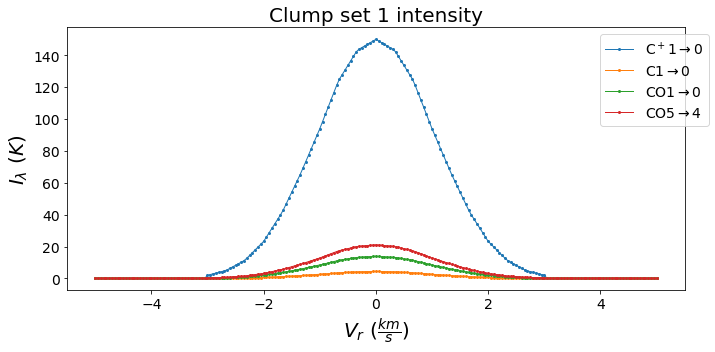

1.0221669673919678 


Density
---------------------
Ensemble 1: 1.000e+05 cm^-3

Clump Masses
---------------------
Ensemble 1: [0.                 0.6666666666666666 1.3333333333333333
 2.                ] M_sol

Clump Radii
---------------------
Ensemble 1: [0.03353179789216207 0.06517141169300307 0.12666523029031185
 0.24618279929357814] pc

Volume Filling Factor
---------------------
Ensemble 1: 0.125

tau_FUV
---------------------
Ensemble 1: 7.810e-01

initialised: 0.09724092483520508
calculated: 0.7532618045806885


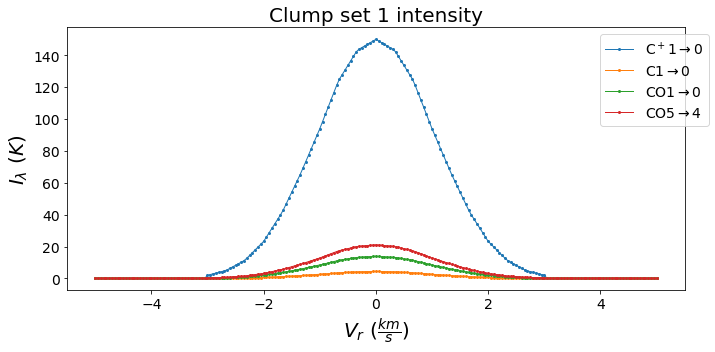

2.3136091232299805 


Density
---------------------
Ensemble 1: 1.000e+05 cm^-3

Clump Masses
---------------------
Ensemble 1: [0.                 0.6666666666666666 1.3333333333333333
 2.                ] M_sol

Clump Radii
---------------------
Ensemble 1: [0.03353179789216207 0.06517141169300307 0.12666523029031185
 0.24618279929357814] pc

Volume Filling Factor
---------------------
Ensemble 1: 0.500

tau_FUV
---------------------
Ensemble 1: 8.169e-01

Maximum intensity:
  large -> C+ 1 149.9770 CO 1 13.8656
  small -> C+ 1 149.9770 CO 1 13.8656
Maximum emissivity:
  large -> C+ 1 180.5445 CO 1 15.4391
  small -> C+ 1 722.3458 CO 1 61.7616
Maximum absorption:
  large -> C+ 1 0.3992 CO 1 0.2157
  small -> C+ 1 1.6020 CO 1 0.8628


In [145]:
%matplotlib inline

inGrid = False
test_fv = True
test_calc = True
test_pexp = False
test_opacity = False
suggested_calc = True

models.constants.n_sigma = 3

models.constants.dtype = np.float32

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = {
                # Model parameters
                'voxel_size' : 1,#0.2,#25.0/3600.0/180.0*np.pi*870.,
                 # 'molecules' : 'all',
                 'molecules' : ['C+ 1', 'C 1', 'C 2', 'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8',
                                '13C+ 1', '13C 1', '13C 2', '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', '13CO 6',
                                '13CO 7', '13CO 8', 'HCO+ 1', 'HCO+ 2', 'HCO+ 3', 'HCO+ 4', 'HCO+ 5'],
                      # 'dust' : ['240um', '550um'],#'PAH',
                      'dust' : 'PAH',
          'clump_mass_range' : [[0, 2]],
         'clump_mass_number' : [4],
               'clump_n_max' : [None],
            'velocity_range' : [-5, 5],
           'velocity_number' : 201,

                # Voxel properties
                  'velocity' : 0,
       'ensemble_dispersion' : 1,#1,
             'ensemble_mass' : [10**2],#7.15, 5.22#10**1,#0.8,
#               'volumeFactor' : [0.8, 0.2],
          'ensemble_density' : [10**5],#4.13, 4.17#10**5,#4.5,
                       'fuv' : 10**6,#1.13, 1.07#1.7,
                      # 'crir' : 2e-16,
    
                # initialisation
                    'dilled' : True,

                # calculation
            'suggested_calc' : suggested_calc,
       'velocity_resolution' : 3,
    
                # logging
                   'verbose' : False,
                     'timed' : False,
                     'debug' : False
          }

if inGrid:
    models.constants.voxel_size = parameters['voxel_size']
#     models.constants.changeMassFunctionParameters(alpha=parameters['alpha'], gamma=parameters['gamma'])
    models.constants.change_velocity_range(parameters['velocityRange'])
    models.constants.change_velocity_number(parameters['velocityNumber'])
    models.constants.add_clumps(massRange=parameters['clumpMassRange'], num=parameters['clumpMassNumber'], Nmax=parameters['clumpNmax'], reset=True)
    models.constants.change_dust_wavelengths(parameters['dust'])
    models.observations.methods.initialise_grid()
    models.species.add_molecules(parameters['molecules'])
    models.interpolations.initialise()
    models.constants.dtype = np.float64

t0 = time()
    
# for p in prop:
scalc = [True, True]
vres = [3, 3]
mass = [231, 77]
delta_s = [1, .25]
voxels = []
for _ in range(2):
    parameters['suggested_calc'] = scalc[min(1, _)]
    parameters['velocity_resolution'] = vres[min(1, _)]
    parameters['ensemble_mass'] = np.array([309])*delta_s[_]**2
    parameters['voxel_size'] = delta_s[_]
    t1 = time()
    vox = models.Voxel()
    vox.set_properties(**parameters)
    print('initialised:', time()-t1)
    vox.calculate_emission(test_calc=test_calc, test_opacity=test_opacity, test_pexp=test_pexp, test_fv=test_fv, verbose=False, timed=False)
    print('calculated:', time()-t1)
    # vox.plot_clump_number(effective=True)
    # vox.plotMolecule(quantity='intensity', kind='slinear', molecule=['C+ 1', 'O 1', 'CO 4', 'CO 45'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{O} 1 \rightarrow 0$', r'$\mathrm{CO} 4 \rightarrow 3$', r'$\mathrm{CO} 45 \rightarrow 46$'])
    vox.plot_molecule(quantity='intensity', kind='slinear', molecule=['C+ 1', 'C 1', 'CO 1', 'CO 5'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{C} 1 \rightarrow 0$', r'$\mathrm{CO} 1 \rightarrow 0$', r'$\mathrm{CO} 5 \rightarrow 4$'])
    # vox.plotSpectrum(quantity='intensity', kind='slinear', integrated=True)
    voxels.append(copy(vox))

    print(time()-t0, '\n')
    print('\nDensity')
    print('---------------------')
    print('\n'.join(['Ensemble {}: {:.3e} cm^-3'.format(_+1, vox.get_density()[_]) for _ in range(models.constants.ensembles)]))
    print('\nClump Masses')
    print('---------------------')
    print('\n'.join(['Ensemble {}: {} M_sol'.format(_+1, models.constants.clump_log_mass[_].flatten()) for _ in range(models.constants.ensembles)]))
    print('\nClump Radii')
    print('---------------------')
    print('\n'.join(['Ensemble {}: {} pc'.format(_+1, models.masspoints.clump_radius[_].flatten()) for _ in range(models.constants.ensembles)]))
    print('\nVolume Filling Factor')
    print('---------------------')
    print('\n'.join(['Ensemble {}: {:.3f}'.format(_+1, vox.get_volume_filling_factor()[_]) for _ in range(models.constants.ensembles)]))
    print('\ntau_FUV')
    print('---------------------')
    print('\n'.join(['Ensemble {}: {:.3e}'.format(_+1, vox.get_taufuv()[_]) for _ in range(models.constants.ensembles)]))
    print()
    
old_vox, new_vox = voxels[:2]
print('Maximum intensity:\n  large -> C+ 1 {:.4f} CO 1 {:.4f}\n  small -> C+ 1 {:.4f} CO 1 {:.4f}'.format(
    old_vox.get_species_intensity(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    old_vox.get_species_intensity(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
    new_vox.get_species_intensity(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    new_vox.get_species_intensity(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
))
print('Maximum emissivity:\n  large -> C+ 1 {:.4f} CO 1 {:.4f}\n  small -> C+ 1 {:.4f} CO 1 {:.4f}'.format(
    old_vox.get_species_emissivity(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    old_vox.get_species_emissivity(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
    new_vox.get_species_emissivity(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    new_vox.get_species_emissivity(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
))
print('Maximum absorption:\n  large -> C+ 1 {:.4f} CO 1 {:.4f}\n  small -> C+ 1 {:.4f} CO 1 {:.4f}'.format(
    old_vox.get_species_absorption(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    old_vox.get_species_absorption(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
    new_vox.get_species_absorption(total=False, include_dust=True)[0][100, models.species.molecules.index('C+ 1')],
    new_vox.get_species_absorption(total=False, include_dust=True)[0][100, models.species.molecules.index('CO 1')],
))

an example for when the ISM completely fills the voxel.

> note that this does not mean $f_\mathrm{V}=1$; it is still a clumpy medium

In [192]:
N = 8
ds = 0.25

i0_c = 149.9770
e_c = 722.3458
k_c = 1.6020
i0_co = 13.8656
e_co = 61.7616
k_co = 0.8628

for e, k, i0 in ((e_c, k_c, i0_c), (e_co, k_co, i0_co)):
    I = i0
    for _ in range(N-1):
        I = np.exp(-k*ds) * ( (e/k)*(np.exp(k*ds)-1) + I )
    print(f'The calculated intensity is {I: .4f} K')

The calculated intensity is  432.6671 K
The calculated intensity is  58.8312 K


uniform medium calculation

In [213]:
test = True  # for testing a new calculation

N = 2
ds = 1
i0_c = 149.9770
e_c = 180.5445
k_c = 0.3992
i0_co = 13.8656
e_co = 15.4391
k_co = 0.215

# N = 1
# ds = 2
# i0_c = 146.3521
# e_c = 87.5642
# k_c = 0.1931
# i0_co = 13.5592
# e_co = 7.5293
# k_co = 0.1051

# this is the area-filling factor of the ISM being modelled and the projected voxel area,
#  NOT the projected area filled by clumps
if test:
    f_V = 0.25/ds
else:
    f_V = 1
print(f'f_V: {f_V}')

if f_V <1:
    i0_c = f_V**(1) * i0_c
    k_c = -np.log(f_V**(1)*np.exp(-k_c*ds*f_V**(0))) / ds
    e_c = i0_c * k_c / (1-np.exp(-k_c*ds*f_V**(0)))
    i0_co = f_V**(1) * i0_co
    k_co = -np.log(f_V**(1)*np.exp(-k_co*ds*f_V**(0))) / ds
    e_co = i0_co * k_co / (1-np.exp(-k_co*ds*f_V**(0)))

for e, k, i0 in ((e_c, k_c, i0_c), (e_co, k_co, i0_co)):
    I = i0
    for _ in range(N-1):
        I = np.exp(-k*ds) * ( (e/k)*(np.exp(k*ds)-1) + I )
    print(f'The calculated intensity is {I: .4f} K')

f_V: 0.25
The calculated intensity is  43.7826 K
The calculated intensity is  4.1653 K


two-layer calculation

In [134]:
forward = False

ds = 0.5
i_c = (329.9942, 149.5710)
e_c = (1130.4383, 359.9875)
k_c = (2.5303, 0.7983)
i_co = (34.5279, 13.8251)
e_co = (94.5885, 30.7804)
k_co = (1.3265, 0.4300)

for e, k, i in ((e_c, k_c, i_c), (e_co, k_co, i_co)):

    if not forward:
        i = i[::-1]
        e = e[::-1]
        k = k[::-1]
    de = (e[1]-e[0]) / ds
    dk = (k[1]-k[0]) / ds
    print(i, e, k, de, dk)

    if dk > 0:
        efun = np.exp((k[1]**2 - (k[1]+dk*ds))/2/dk)*np.exp(-k[1]**2/2/dk)*erfi(k[1]/np.sqrt(2*dk)) - np.exp(-(k[1]+dk*ds)**2/2/dk)*erfi((k[1]+dk*ds)/np.sqrt(2*dk))
    else:
        efun = np.exp((k[1]**2 - (k[1]+dk*ds))/2/dk)*np.exp(np.abs(k[1]**2/2/dk))*erfc(k[1]/np.sqrt(2*np.abs(dk))) - np.exp(np.abs((k[1]+dk*ds)**2/2/dk))*erfc((k[1]+dk*ds)/np.sqrt(2*np.abs(dk)))

    print(efun)

    I = ( de/dk*(1-np.exp(-k[1]*ds-0.5*dk*ds**2)) - (e[1]*dk-k[1]*de)/dk * np.sqrt(np.pi/2/np.abs(dk)) * efun ) \
        + i[0]*np.exp(-k[1]*ds-0.5*dk*ds**2)
    
    print(f'The calculated intensity is {I: .4f} K')

(149.571, 329.9942) (359.9875, 1130.4383) (0.7983, 2.5303) 1540.9016000000001 3.464
0.385147804392939
The calculated intensity is  389.5287 K
(13.8251, 34.5279) (30.7804, 94.5885) (0.43, 1.3265) 127.61619999999999 1.7930000000000001
-0.07225173923511952
The calculated intensity is  47.5737 K


misc

In [110]:
vox.get_species_intensity(total=False, include_dust=True)[0][100, 0]

254.84169521797924

In [142]:
0.5*1e5*(3.086**3*1.67/1.988)*10**-3*1*1*.25

308.6013838878269

(19,)

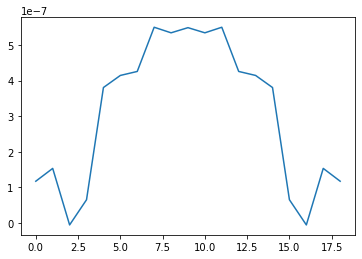

In [73]:
y = vox.get_species_absorption(total=False, include_dust=True, fit=False)[0][:, models.species.molecules.index('13CO 1')]
plt.plot(y)
y.shape

In [26]:
len(models.species.molecules)

27

In [25]:
vox._Voxel__absorption_species[0].shape

(19, 27)

In [23]:
models.combinations.clump_species_optical_depth[0].shape

(54, 27)

In [27]:
models.ensemble.clumpProbability[0].shape

(19, 54, 4)

Text(0, 0.5, '$\\mathcal{P}$')

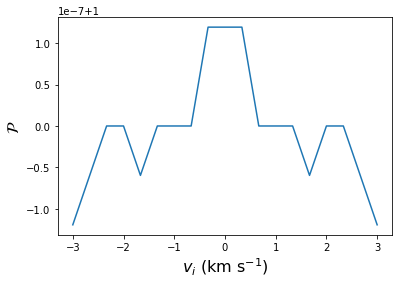

In [77]:
np.set_printoptions(precision=32)
plt.plot(models.ensemble.clumpVelocities[0], (models.ensemble.clumpProbability[0].prod(2)[:, :]/models.ensemble.clumpProbability[0].prod(2).sum(1).reshape(-1, 1)).sum(1))
plt.xlabel(r'$v_i$ (km s$^{-1}$)', fontsize=16)
plt.ylabel(r'$\mathcal{P}$', fontsize=16)

Text(0, 0.5, '$\\mathcal{P}\\mathrm{exp}(-)$')

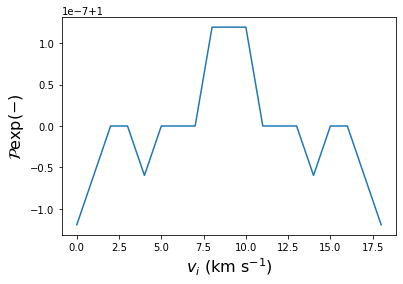

In [82]:
l = []
for i,p in enumerate(models.ensemble.clumpProbability[0]):
    l.append((p.prod(1)/p.prod(1).sum(0)).sum(0))
plt.plot(np.array(l))
plt.xlabel(r'$v_i$ (km s$^{-1}$)', fontsize=16)
plt.ylabel(r'$\mathcal{P}\mathrm{exp}(-)$', fontsize=16)
#plt.ylim(0.99999, 1.00001)

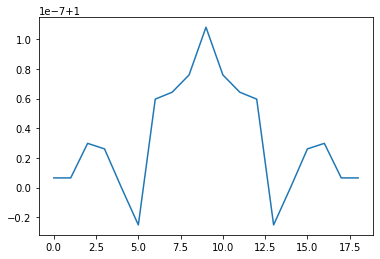

In [89]:
l = []
ens = 2
for i,p in enumerate(models.ensemble.clumpProbability[ens]):
    l.append((p.prod(1)/p.prod(1).sum(0)*np.exp(-models.combinations.clump_species_optical_depth[ens].T)).sum(1))
plt.plot(np.array(l)[:, models.species.molecules.index('CO 1')])
#plt.ylim(0.99999, 1.00001)

In [ ]:
models.ensemble.clumpVelocities

In [39]:
l = []
l.append(1, 2, 3)
l

TypeError: append() takes exactly one argument (3 given)

In [56]:
np.sum(models.constants.clumpMassNumber)

6

In [50]:
np.hstack(models.ensemble.clumpNj)

array([[1.32368147e+01, 1.91330184e+00, 2.76556257e-01, 3.99745413e-02,
        1.00000000e-01, 1.00000000e+02]])

In [55]:
np.hstack(models.masspoints.clumpRadius)

array([[0.05879007, 0.15929583, 0.43162327, 1.16951362, 0.43287596,
        0.0432876 ]])

In [32]:
models.ensemble.clumpVelocities

[array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.])]

In [28]:
np.append(*(n for n in models.ensemble.clumpNj))

array([1.32368147e-01, 1.91330184e-02, 2.76556257e-03, 3.99745413e-04,
       1.00000000e+00])

In [ ]:
voxels_

In [11]:
models.masspoints.clumpRadius

[array([[2.1297766]])]

In [12]:
len(models.interpolations.dustIntensityInterpolation), models.constants.dust

(201, 'PAH')

In [12]:
eps_spe = new_vox.getSpeciesEmissivity(total=False)

In [15]:
eps_dust, eps_dust_old = new_vox.getDustEmissivity(minimal=True), old_vox.getDustEmissivity(minimal=True)

In [16]:
eps_dust, eps_dust_old

(array([2.02317148e-05, 1.11847806e-05]),
 array([2.02317145e-05, 1.11847804e-05]))

In [14]:
eps_spe[0].shape, eps_dust[0].mean(1).shape

((701, 27), (701,))

In [18]:
models.constants.dust

'all'

In [8]:
models.ensemble.CLmaxProbability

[array([[0.7597717 , 0.75326645, 0.71191967, 0.69236493],
        [0.7597717 , 0.75326645, 0.71191967, 0.30763507],
        [0.7597717 , 0.75326645, 0.25247508, 0.69236493],
        [0.7597717 , 0.75326645, 0.25247508, 0.30763507],
        [0.7597717 , 0.75326645, 0.03357664, 0.69236493],
        [0.7597717 , 0.75326645, 0.03357664, 0.30763507],
        [0.20933615, 0.75326645, 0.71191967, 0.69236493],
        [0.20933615, 0.75326645, 0.71191967, 0.30763507],
        [0.20933615, 0.75326645, 0.25247508, 0.69236493],
        [0.20933615, 0.75326645, 0.25247508, 0.30763507],
        [0.20933615, 0.75326645, 0.03357664, 0.69236493],
        [0.20933615, 0.75326645, 0.03357664, 0.30763507],
        [0.02823787, 0.75326645, 0.71191967, 0.69236493],
        [0.02823787, 0.75326645, 0.71191967, 0.30763507],
        [0.02823787, 0.75326645, 0.25247508, 0.69236493],
        [0.02823787, 0.75326645, 0.25247508, 0.30763507],
        [0.02823787, 0.75326645, 0.03357664, 0.69236493],
        [0.028

In [35]:
models.ensemble.clumpLargestIndex

[0, 3]

In [19]:
[eps_spe[0][:, spe] + eps_dust[0].mean(1) for spe in range(eps_spe.shape[2])][0][:10]

array([6.37396893e-05, 6.37396893e-05, 6.37396893e-05, 6.37396893e-05,
       6.37396893e-05, 6.37396893e-05, 6.37396893e-05, 6.37396893e-05,
       6.37396893e-05, 6.37396893e-05])

In [32]:
old_vox.suggested_calc

False

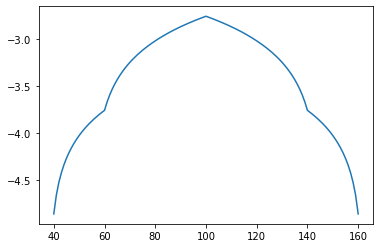

In [11]:
plt.plot(np.log10(old_vox.get_species_emissivity(include_dust=False, total=True)[:, models.species.molecules.index('13CO 1')]))

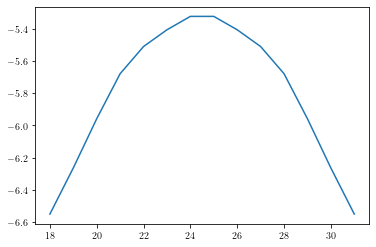

In [69]:
plt.plot(np.log10(new_vox.getSpeciesEmissivity(include_dust=False, total=True)[:, 0]))

In [52]:
np.log10((np.arange(5, 55), np.linspace(10, 1, num=50)))

array([[0.69897   , 0.77815125, 0.84509804, 0.90308999, 0.95424251,
        1.        , 1.04139269, 1.07918125, 1.11394335, 1.14612804,
        1.17609126, 1.20411998, 1.23044892, 1.25527251, 1.2787536 ,
        1.30103   , 1.32221929, 1.34242268, 1.36172784, 1.38021124,
        1.39794001, 1.41497335, 1.43136376, 1.44715803, 1.462398  ,
        1.47712125, 1.49136169, 1.50514998, 1.51851394, 1.53147892,
        1.54406804, 1.5563025 , 1.56820172, 1.5797836 , 1.59106461,
        1.60205999, 1.61278386, 1.62324929, 1.63346846, 1.64345268,
        1.65321251, 1.66275783, 1.67209786, 1.68124124, 1.69019608,
        1.69897   , 1.70757018, 1.71600334, 1.72427587, 1.73239376],
       [1.        , 0.991949  , 0.98374592, 0.97538491, 0.96685977,
        0.95816393, 0.94929041, 0.94023179, 0.9309802 , 0.92152723,
        0.91186391, 0.90198068, 0.89186728, 0.88151275, 0.8709053 ,
        0.86003227, 0.84888002, 0.83743382, 0.82567776, 0.8135946 ,
        0.80116561, 0.78837042, 0.77518677, 0.7

In [6]:
new_vox.getFUV()

[1000, 1000]

In [44]:
new_vox.plotSpectrum(quantity='optical depth')

Quantity optical depth not available.


In [5]:
(1, 2, 3)[1:]

(2, 3)

In [16]:
np.where(models.constants.nDust)[0].size

True

In [21]:
models.constants.wavelengths[models.constants.nDust]

array([0.00055, 0.00024])

In [5]:
models.constants.dustNames[models.constants.nDust]

array(['550um', '240um'], dtype='<U7')

In [7]:
new_vox.getDustAbsorption().shape

(71, 201)

## Plotting comparisons

In [4]:
import os

if not os.path.exists('debugging_plot'):
    os.mkdir('debugging_plot')

In [6]:
ens = 0
value = new_vox._Voxel__intensitySpecies[0]
value_interp = new_vox.getSpeciesIntensity(kind='linear', include_dust=False)
value_fit = new_vox.getSpeciesIntensity(kind='gaussian', include_dust=False)
for i, molecule in enumerate(models.species.molecules):
    print(molecule)
    plt.figure(figsize=(15, 10))
    plt.plot(new_vox._Voxel__clumpVelocities[0][new_vox._Voxel__clumpVelocityIndeces[0]], value[:, i], lw=3, marker='+', ms=3, label='calculated')
    plt.plot(models.constants.velocityRange, value_interp[:, i], marker='x', lw=1, ms=2, label='interpolated')
    plt.plot(models.constants.velocityRange, value_fit[:, i], marker='x', lw=1, ms=2, label='fitted')
    plt.legend()
    plt.savefig('debugging_plot/{}_{}_test.png'.format(i, molecule.replace(' ', '')), format='png', transparent=False)
    plt.close()

/home/yanitski/anaconda3/envs/test/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


C+ 1
C 1
C 2
C 3
O 1
O 2
O 3
CO 1
CO 2
CO 3
CO 4
CO 5
CO 6
CO 7
CO 8
CO 9
CO 10
CO 11
CO 12
CO 13
CO 14
CO 15
CO 16
CO 17
CO 18
CO 19
CO 20
CO 21
CO 22
CO 23
CO 24
CO 25
CO 26
CO 27
CO 28
CO 29
CO 30
CO 31
CO 32
CO 33
CO 34
CO 35
CO 36
CO 37
CO 38
CO 39
CO 40
CO 41
CO 42
CO 43
CO 44
CO 45
CO 46
CO 47
CO 48
CO 49
13CO 1
13CO 2
13CO 3
13CO 4
13CO 5
13CO 6
13CO 7
13CO 8
13CO 9
13CO 10
13CO 11
13CO 12
13CO 13
13CO 14
13CO 15
13CO 16
13CO 17
13CO 18
13CO 19
13CO 20
13CO 21
13CO 22
13CO 23
13CO 24
13CO 25
13CO 26
13CO 27
13CO 28
13CO 29
13CO 30
13CO 31
13CO 32
13CO 33
13CO 34
13CO 35
13CO 36
13CO 37
13CO 38
13CO 39
13CO 40
13CO 41
13CO 42
13CO 43
13CO 44
13CO 45
13CO 46
13CO 47
13CO 48
13CO 49
13C+ 1
13C 1
13C 2
13C 3
HCO+ 1
HCO+ 2
HCO+ 3
HCO+ 4
HCO+ 5
HCO+ 6
HCO+ 7
HCO+ 8
HCO+ 9
HCO+ 10
HCO+ 11
HCO+ 12
HCO+ 13
HCO+ 14
HCO+ 15
H13CO+ 1
H13CO+ 2
H13CO+ 3
H13CO+ 4
H13CO+ 5
H13CO+ 6
H13CO+ 7
H13CO+ 8
H13CO+ 9
H13CO+ 10
H13CO+ 11
H13CO+ 12
H13CO+ 13
H13CO+ 14
H13CO+ 15
H13CO+ 16
H13CO+ 17
H13CO+

## file interpolation test

In [14]:
import os
import dill

if not os.path.exists('dilled'):
    os.mkdir('dilled')

### create dilled files

In [3]:
t0 = time()
models.constants.changeDustWavelengths('all')
models.observations.methods.initialise()
t1 = time()
models.species.addMolecules('all')
models.interpolations.initialise()
time()-t1, t1-t0

(133.8041319847107, 0.8136382102966309)

In [4]:
models.constants.changeDustWavelengths('all')
models.observations.methods.initialise()
models.species.addMolecules('all')
models.interpolations.initialise()

In [4]:
len(models.interpolations.intensityInterpolation)

171

In [7]:
with open('dilled/intensity_interpolation_dilled', 'wb') as file:
    dill.dump(models.interpolations.intensityInterpolation, file)
with open('dilled/tau_interpolation_dilled', 'wb') as file:
    dill.dump(models.interpolations.tauInterpolation, file)
with open('dilled/dust_intensity_interpolation_dilled', 'wb') as file:
    dill.dump(models.interpolations.dustIntensityInterpolation, file)
with open('dilled/dust_tau_interpolation_dilled', 'wb') as file:
    dill.dump(models.interpolations.dustTauInterpolation, file)
with open('dilled/fuv_extinction_interpolation_dilled', 'wb') as file:
    dill.dump(models.interpolations.FUVextinctionInterpolation, file)

### time dilled method

In [2]:
t0 = time()
with open('dilled/intensity_interpolation_dilled', 'rb') as file:
    fn0 = dill.load(file)
with open('dilled/tau_interpolation_dilled', 'rb') as file:
    fn1 = dill.load(file)
with open('dilled/dust_intensity_interpolation_dilled', 'rb') as file:
    fn2 = dill.load(file)
with open('dilled/dust_tau_interpolation_dilled', 'rb') as file:
    fn3 = dill.load(file)
with open('dilled/fuv_extinction_interpolation_dilled', 'rb') as file:
    fn9 = dill.load(file)
time()-t0

0.6938478946685791

In [3]:
with open('dilled/file', 'wb') as file:
    dill.dumps(f0, file)

FileNotFoundError: [Errno 2] No such file or directory: 'dilled/file'

In [15]:
with open('dilled/fuv_extinction_interpolation_dilled', 'rb') as file:
    print(dill.load(file))

## Comparison to old calculation

### self-absorption issue

There is a self-absorption issue with the single-voxel model due to how the intensity is calculated. Below we investigate a possible solution to this issue, which we will document here until it is implemented.

*Volker:*
> Monochromatcally, i.e. for each velocity, we have the emissivity of a single clump as $\epsilon_{clump} = I_{clump}\frac{\tau_{clump}}{L_{clump}}/[1-\exp(-\tau_{clump})]$
where $L_{clump}$ is the physical mean length of the clump (drops out later). Opacities and emissivities are directly additive. That means that for the cell we get an emissivity
$$
\epsilon_{cell} = \sum_{clumps} \frac{I_{clump} \times A_{clump} \times \tau_{clump}}{[1-\exp(-\tau_{clump})] \times V_{cell}}
$$

> for the ensemble opacity we have $\kappa_x=\sum_{clumps} \frac{ \tau_{clump}\times A_{clump}}{V_{cell}}$ which has to be used with the corresponding probability in Eqs. (5.23) or (5.35) from Silke's thesis to get $\kappa_{cell}$. Then we are back at the standard RT equation for each cell: 
$$
I_{cell}=\frac{\epsilon_{cell}}{\kappa_{cell}}[1-\exp(-\tau_{cell})].
$$

Comparison with the standard single-voxel example:

### old calculation

74.10818982124329
74.10845875740051 


Volume Filling Factor
---------------------
Clump 1: 4.047

Density
---------------------
Clump 1: 1.000e+05



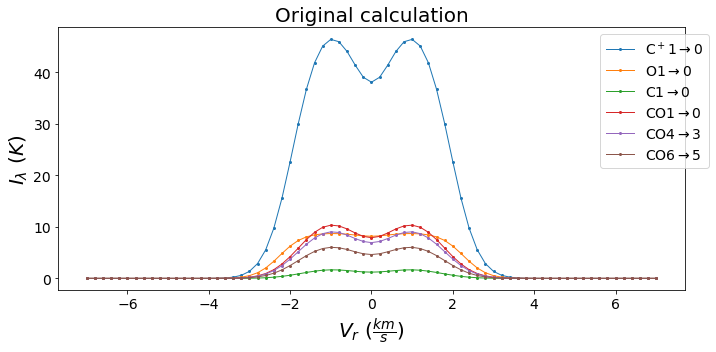

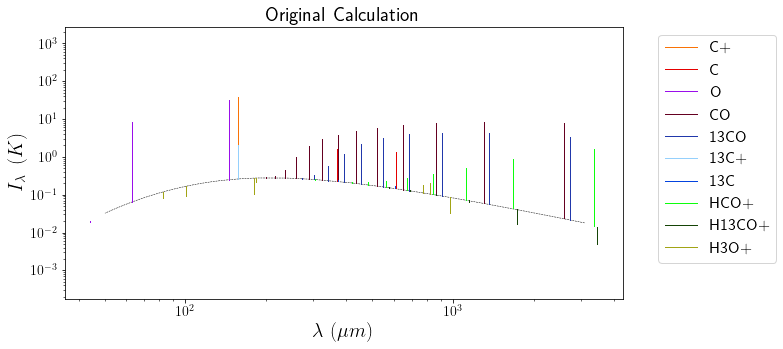

179.31981126846696

In [2]:
%matplotlib inline

test_calc = False
test_opacity = False
test_pexp = False
test_fv = True

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = {
                # Model parameters#25.0/3600.0/180.0*np.pi*870.,#
                'voxel_size' : 0.1,
                 'molecules' : 'all',
#                  'molecules' : ['C+ 1', 'C 1', 'CO 1'],
                      # 'dust' : 'PAH',
                      'dust' : 'molecular',
            'clumpMassRange' : [[1]],
           'clumpMassNumber' : [1],
                 'clumpNmax' : [1],
             'velocityRange' : [-7, 7],
            'velocityNumber' : 71,
       'velocity_resolution' : 1,

                # Voxel properties
                  'velocity' : 0,
        'ensembleDispersion' : 1,
              'ensembleMass' : 10,
#               'volumeFactor' : [0.8, 0.2],
           'ensembleDensity' : 10**5,
                       'FUV' : 10**4,
                      # 'crir' : 2e-16,
    
                # logging
                   'verbose' : True,
                     'timed' : False,
                     'debug' : False
          }

t0 = time()
    
# for p in prop:
for _ in range(1):
    t1 = time()
    old_vox = models.Voxel()
    old_vox.setProperties(**parameters)
    old_vox.calculateEmission(test_calc=test_calc, test_opacity=test_opacity, test_pexp=test_pexp, test_fv=test_fv, 
                          verbose=False, timed=False)
    print(time()-t1)

print(time()-t0, '\n')
print('\nVolume Filling Factor')
print('---------------------')
print('\n'.join(['Clump {}: {:.3f}'.format(_+1, old_vox.getVolumeFillingFactor()[_]) for _ in range(models.constants.ensembles)]))
print('\nDensity')
print('---------------------')
print('\n'.join(['Clump {}: {:.3e}'.format(_+1, old_vox.getDensity()[_]) for _ in range(models.constants.ensembles)]))
print()
# vox.plotMolecule(quantity='intensity', molecule=['C+ 1', 'C 1', 'CO 1'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{C} 1 \rightarrow 0$', r'$\mathrm{CO} 1 \rightarrow 0$'], title='Dense voxel')
old_vox.plotMolecule(quantity='intensity', 
                     molecule=['C+ 1', 
                               'O 1', 
                               'C 1', 
                               'CO 1', 
                               'CO 4', 
                               'CO 6'], 
                     moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', 
                                   r'$\mathrm{O} 1 \rightarrow 0$', 
                                   r'$\mathrm{C} 1 \rightarrow 0$', 
                                   r'$\mathrm{CO} 1 \rightarrow 0$', 
                                   r'$\mathrm{CO} 4 \rightarrow 3$', 
                                   r'$\mathrm{CO} 6 \rightarrow 5$',
                                   r'$$'],
                     title='Original calculation')
old_vox.plotSpectrum(quantity='intensity', title='Original Calculation')
# plt.show()
old_vox.getSpeciesIntensity(integrated=True)[0, 0]

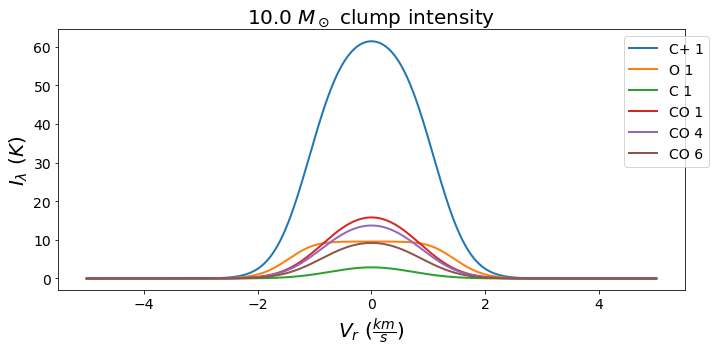

In [10]:
models.masspoints.plotIntensity(quantity='intensity', 
                                molecule=['C+ 1', 
                                          'O 1', 
                                          'C 1', 
                                          'CO 1', 
                                          'CO 4', 
                                          'CO 6'],
                                test_calc=False)

### new calculation

0.36051225662231445
0.36076855659484863 


Volume Filling Factor
---------------------
Clump 1: 4.047

Density
---------------------
Clump 1: 1.000e+05



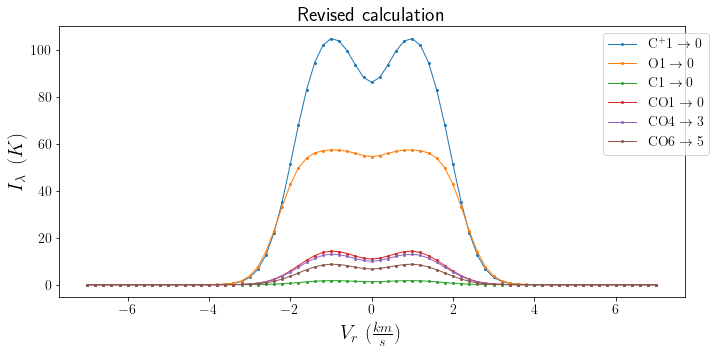

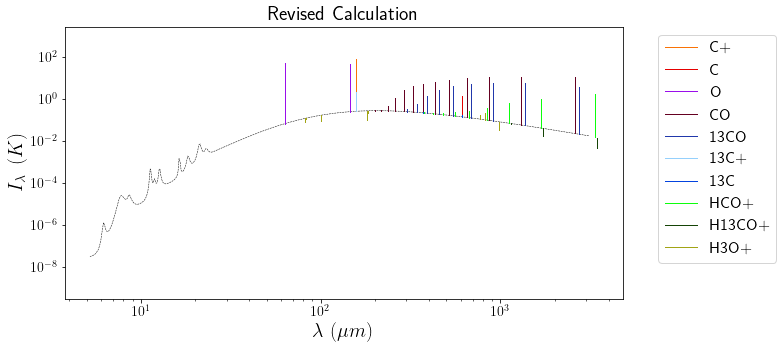

405.29682580216996

In [3]:
%matplotlib inline

test_calc = True
test_opacity = False
test_pexp = False
test_fv = True

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = {
                # Model parameters#25.0/3600.0/180.0*np.pi*870.,#
                'voxel_size' : 0.1,
                 'molecules' : 'all',
#                  'molecules' : ['C+ 1', 'C 1', 'CO 1'],
                      'dust' : 'PAH',
#                       'dust' : 'molecular',
            'clumpMassRange' : [[1]],
           'clumpMassNumber' : [1],
                 'clumpNmax' : [1],
             'velocityRange' : [-7, 7],
            'velocityNumber' : 71,
       'velocity_resolution' : 1,

                # Voxel properties
                  'velocity' : 0,
        'ensembleDispersion' : 1,
              'ensembleMass' : 10,
#               'volumeFactor' : [0.8, 0.2],
           'ensembleDensity' : 10**5,
                       'FUV' : 10**4,
                      # 'crir' : 2e-16,
    
                # logging
                   'verbose' : True,
                     'timed' : False,
                     'debug' : False
          }

t0 = time()
    
# for p in prop:
for _ in range(1):
    t1 = time()
    new_vox = models.Voxel()
    new_vox.setProperties(**parameters)
    new_vox.calculateEmission(test_calc=test_calc, test_opacity=test_opacity, test_pexp=test_pexp, test_fv=test_fv, 
                          verbose=False, timed=False)
    print(time()-t1)

print(time()-t0, '\n')
print('\nVolume Filling Factor')
print('---------------------')
print('\n'.join(['Clump {}: {:.3f}'.format(_+1, new_vox.getVolumeFillingFactor()[_]) for _ in range(models.constants.ensembles)]))
print('\nDensity')
print('---------------------')
print('\n'.join(['Clump {}: {:.3e}'.format(_+1, new_vox.getDensity()[_]) for _ in range(models.constants.ensembles)]))
print()
# vox.plotMolecule(quantity='intensity', molecule=['C+ 1', 'C 1', 'CO 1'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{C} 1 \rightarrow 0$', r'$\mathrm{CO} 1 \rightarrow 0$'], title='Dense voxel')
new_vox.plotMolecule(quantity='intensity', 
                     molecule=['C+ 1', 
                               'O 1', 
                               'C 1', 
                               'CO 1', 
                               'CO 4', 
                               'CO 6'], 
                     moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', 
                                   r'$\mathrm{O} 1 \rightarrow 0$', 
                                   r'$\mathrm{C} 1 \rightarrow 0$', 
                                   r'$\mathrm{CO} 1 \rightarrow 0$', 
                                   r'$\mathrm{CO} 4 \rightarrow 3$', 
                                   r'$\mathrm{CO} 6 \rightarrow 5$'],
                     title='Revised calculation')
new_vox.plotSpectrum(quantity='intensity', title='Revised Calculation')
# plt.show()
new_vox.getSpeciesIntensity(integrated=True)[0, 0]

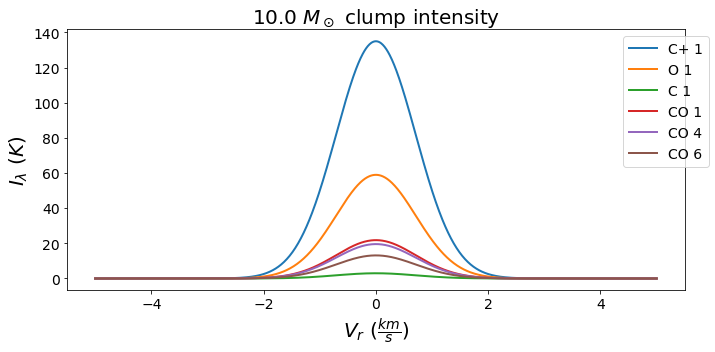

In [5]:
models.masspoints.plotIntensity(quantity='intensity', 
                                molecule=['C+ 1', 
                                          'O 1', 
                                          'C 1', 
                                          'CO 1', 
                                          'CO 4', 
                                          'CO 6'],
                                test_calc=True)

### velocity resolution

In [4]:
%matplotlib inline

# Use these to change the voxel properties, which is necessary in the default mode.
parameters = {
                # Model parameters#25.0/3600.0/180.0*np.pi*870.,#
                'voxel_size' : 0.1,
                 'molecules' : 'all',
                      'dust' : 'PAH',
            'clumpMassRange' : [[1]],
           'clumpMassNumber' : [1],
                 'clumpNmax' : [1],
             'velocityRange' : [-7, 7],
            'velocityNumber' : 71,
       'velocity_resolution' : 3,

                # Voxel properties
                  'velocity' : 0,
        'ensembleDispersion' : 1,
              'ensembleMass' : 10,
           'ensembleDensity' : 10**5,
                       'FUV' : 10**4,
                      # 'crir' : 2e-16,
    
                # logging
                   'verbose' : True,
                     'timed' : False,
                     'debug' : False
          }


f_velocity = np.arange(1, 30)
species = ['C+ 1', 
           'C 1', 'C 2', 'C 3', 
           'O 1', 'O 2', 'O 3', 
           'CO 1', 'CO 2', 'CO 3', 'CO 4', 'CO 5', 'CO 6', 'CO 7', 'CO 8', 'CO 9', 'CO 10', 
           'CO 11', 'CO 12', 'CO 13', 'CO 14', 'CO 15', 'CO 16', 'CO 17', 'CO 18', 'CO 19', 'CO 20', 
           'CO 21', 'CO 22', 'CO 23', 'CO 24', 'CO 25', 'CO 26', 'CO 27', 'CO 28', 'CO 29', 'CO 30', 
           'CO 31', 'CO 32', 'CO 33', 'CO 34', 'CO 35', 'CO 36', 'CO 37', 'CO 38', 'CO 39', 'CO 40', 
           'CO 41', 'CO 42', 'CO 43', 'CO 44', 'CO 45', 'CO 46', 'CO 47', 'CO 48', 'CO 49', 
           '13CO 1', '13CO 2', '13CO 3', '13CO 4', '13CO 5', '13CO 6', '13CO 7', '13CO 8', '13CO 9', '13CO 10', 
           '13CO 11', '13CO 12', '13CO 13', '13CO 14', '13CO 15', '13CO 16', '13CO 17', '13CO 18', '13CO 19', '13CO 20', 
           '13CO 21', '13CO 22', '13CO 23', '13CO 24', '13CO 25', '13CO 26', '13CO 27', '13CO 28', '13CO 29', '13CO 30', 
           '13CO 31', '13CO 32', '13CO 33', '13CO 34', '13CO 35', '13CO 36', '13CO 37', '13CO 38', '13CO 39', '13CO 40', 
           '13CO 41', '13CO 42', '13CO 43', '13CO 44', '13CO 45', '13CO 46', '13CO 47', '13CO 48', '13CO 49', 
           '13C+ 1', 
           '13C 1', '13C 2', '13C 3', 
           'HCO+ 1', 'HCO+ 2', 'HCO+ 3', 'HCO+ 4', 'HCO+ 5', 'HCO+ 6', 'HCO+ 7', 
           'HCO+ 8', 'HCO+ 9', 'HCO+ 10', 'HCO+ 11', 'HCO+ 12', 'HCO+ 13', 'HCO+ 14', 'HCO+ 15', 
           'H13CO+ 1', 'H13CO+ 2', 'H13CO+ 3', 'H13CO+ 4', 'H13CO+ 5', 'H13CO+ 6', 'H13CO+ 7', 'H13CO+ 8', 'H13CO+ 9', 'H13CO+ 10', 
           'H13CO+ 11', 'H13CO+ 12', 'H13CO+ 13', 'H13CO+ 14', 'H13CO+ 15', 'H13CO+ 16', 'H13CO+ 17', 'H13CO+ 18', 'H13CO+ 19', 'H13CO+ 20', 
           'H13CO+ 21', 'H13CO+ 22', 'H13CO+ 23', 'H13CO+ 24', 'H13CO+ 25', 'H13CO+ 26', 'H13CO+ 27', 'H13CO+ 28', 'H13CO+ 29', 'H13CO+ 30', 
           'H3O+ 1', 'H3O+ 2', 'H3O+ 3', 'H3O+ 4', 'H3O+ 5', 'H3O+ 6', 'H3O+ 7', 'H3O+ 8', 'H3O+ 9', 
           'H3O+ 10', 'H3O+ 11', 'H3O+ 12', 'H3O+ 13', 'H3O+ 14', 'H3O+ 15', 'H3O+ 16', 'H3O+ 17']
old_calculation = np.zeros((len(species), f_velocity.size))
new_calculation = np.zeros((len(species), f_velocity.size))

for i, f in enumerate(f_velocity):
    
    parameters['velocity_resolution'] = f
    
    old_vox = models.Voxel()
    old_vox.setProperties(**parameters)
    old_vox.calculateEmission(test_calc=False, test_fv=True, verbose=False, timed=False)
    old_integrated_intensity = old_vox.getSpeciesIntensity(integrated=True)[0, :]
    
    new_vox = models.Voxel()
    new_vox.setProperties(**parameters)
    new_vox.calculateEmission(test_calc=True, test_fv=True, verbose=False, timed=False)
    new_integrated_intensity = new_vox.getSpeciesIntensity(integrated=True)[0, :]
    
    for j, transition in enumerate(species):
        old_calculation[j, i] = old_integrated_intensity[models.species.molecules.index(species[j])]
        new_calculation[j, i] = new_integrated_intensity[models.species.molecules.index(species[j])]

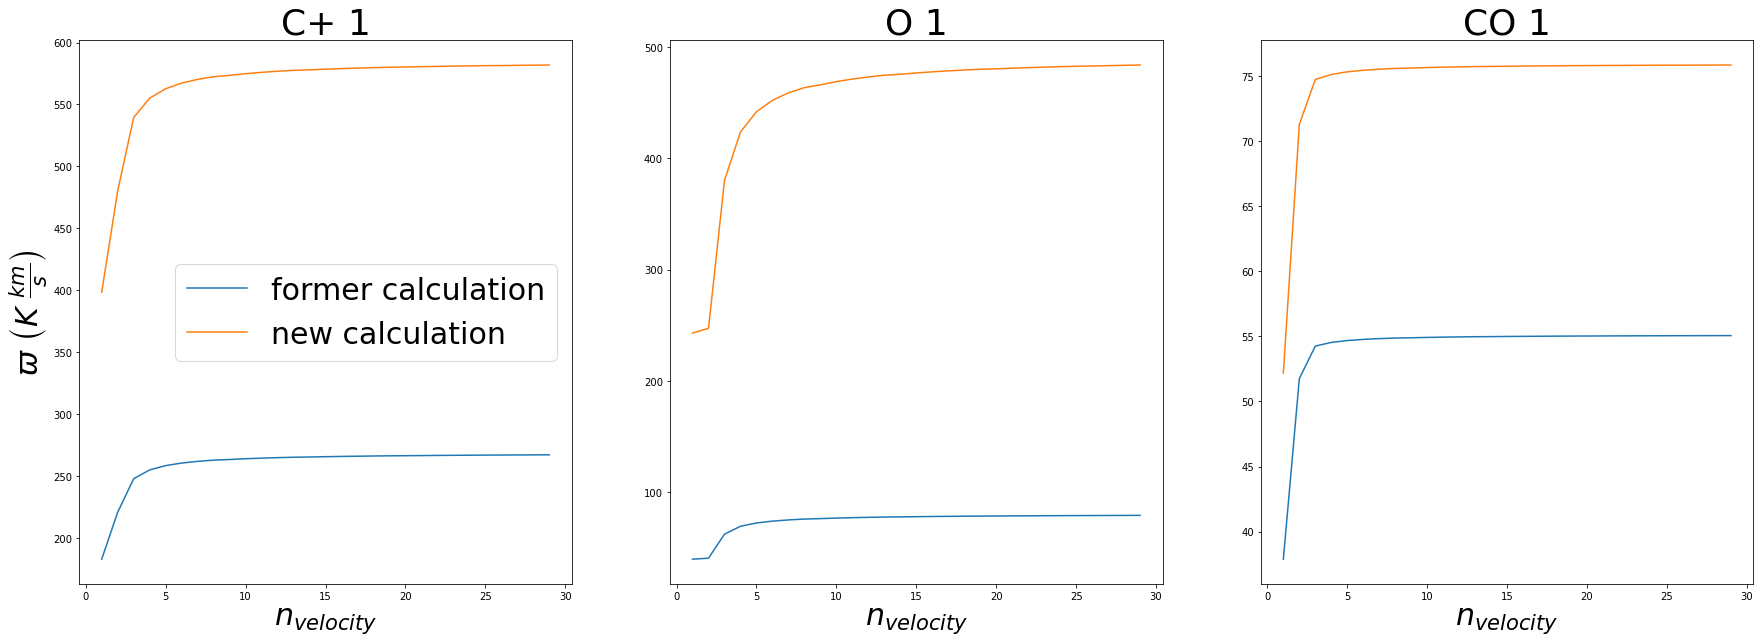

In [7]:
fs = 30

transitions = ['C+ 1', 'O 1', 'CO 1'] #['C 1', 'CO 4', 'CO 6'] #

fig, axes = plt.subplots(1, len(transitions), figsize=(10*len(transitions), 10))

for j, transition in enumerate(transitions):
    axes[j].plot(f_velocity, old_calculation[species.index(transition), :], label='former calculation')
    axes[j].plot(f_velocity, new_calculation[species.index(transition), :], label='new calculation')
    axes[j].set_xlabel(r'$n_{velocity}$', fontsize=fs)
    axes[j].set_title(transition, fontsize=fs+6)
    
axes[0].set_ylabel(r'$\varpi \ \left( K \ \frac{km}{s} \right)$', fontsize=fs)
axes[0].legend(loc='right', fontsize=fs)

plt.show()